In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [61]:
def generate_random_samples(batch, read = "/Users/maks/Documents/MSc_project/data/features", sequence_length = 60):
    """
    A function that creates a list of independent arrays that are to serve as samples for processing later.
    read is the directory where Excel files containing variables are stored;
    batch is the number of samples that will be generated;
    sequence length is the length of each sample.
    Returns a list of numpy arrays.
    """

    def load_excel(file_path):
        """
        Extracts sheets from Excel files given a file directory.
        """
        excel_file = pd.ExcelFile(file_path)
        
        sheets = {sheet_name: pd.read_excel(excel_file, sheet_name = sheet_name) for sheet_name in excel_file.sheet_names}

        return sheets
    
    def random_file(read):
        """
        Chooses a random file from a provided directory.
        """
        files = [f for f in os.listdir(read) if f.endswith(".xlsx") and not f.startswith(".")]
        
        if not files:
            raise FileNotFoundError("No Excel files found in the directory")
        
        return os.path.join(read, random.choice(files))
    
    def normalise_columns(df, columns):
        """
        Normalises specified columns between -1 and 1.
        """
        df = df.copy()  # Make a copy to avoid modifying the original DataFrame
    
        for column in columns:
            max_val = df[column].max()
            min_val = df[column].min()
            
            df.loc[:, column] = 2 * (df[column] - min_val) / (max_val - min_val) - 1

        return df

    def sampler(sheet_data, sequence_length):
        """
        Randomly creates a sample from an Excel sheet.
        sheet_data are sheets representing time series segments from where data is going to be sampled
        sequence_length is the number of points each sample will contain.
        """

        #Normalises velocities and angular velocities using normalise_columns
        columns = ["velocity_x", "velocity_y", "velocity_z","tortuosity3d", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]
        sheet_data = normalise_columns(sheet_data, columns)

        num_points = len(sheet_data)

        if num_points < sequence_length + 2:
            return None
        
        start_index = random.randint(2, num_points - sequence_length)
        end_index = start_index + sequence_length
        sample = sheet_data.iloc[start_index : end_index].to_numpy()

        return sample #Transposes the samle to switch rows and columns
    
    def weighted_random_choice(sheets):
        """
        Assigns weights to sheets based on the length of each sheet.
        """
        total_points = sum(len(data) for data in sheets.values())
        weights = [len(data) / total_points for data in sheets.values()]

        return random.choices(list(sheets.keys()), weights = weights, k = 1)[0]
    
    #Initializes list to strore sample arrays
    samples = []

    while len(samples) < batch:
        file_path = random_file(read)
        sheets = load_excel(file_path)

        while len(samples) < batch:
            sheet_name = weighted_random_choice(sheets)
            sheet_data = sheets[sheet_name][["velocity_x", "velocity_y", "velocity_z", "tortuosity3d", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]]
            sample = sampler(sheet_data, sequence_length)

            if sample is not None:
                samples.append(sample)

            #Stops once batch size is reached
            if len(samples) >= batch:
                break

    return samples

In [62]:
#Class to contain our sampled time series data
class TimeSeriesData(Dataset):
    def __init__(self, no_samples):
        self.data = generate_random_samples(no_samples)
        self.data = torch.tensor(self.data, dtype = torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]
    

In [63]:
#Convolutional autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels = 7, out_channels = 32, kernel_size = 3, stride = 1, padding = 1), #output: (16, 60)
            #nn.BatchNorm1d(16),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2), #output (16, 30)

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), #output: (32, 30)
            #nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2), #output: (32, 15)
            nn.Dropout(0.1)
        )

        #Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2), #output: (16, 30)
            #nn.BatchNorm1d(16),
            nn.ELU(),

            nn.ConvTranspose1d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 2, padding = 1, output_padding = 1), #output: (8, 60)
            #nn.BatchNorm1d(8),
            nn.ELU(),
            nn.ConvTranspose1d(in_channels = 16, out_channels = 7, kernel_size = 3, stride = 1, padding = 1), #output: (7, 60)
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.permute(0, 2, 1)
        return decoded
    
    def encode(self, x):
        x = x.permute(0, 2, 1)
        encoded = self.encoder(x)
        return encoded

In [64]:
#Dataset and dataloader parameters
no_samples = 480
batch_size = 32

In [65]:
#Model, loss function and optimiser
model = ConvAutoencoder()
criterion = nn.L1Loss()
optimiser = optim.AdamW(model.parameters(), lr = 0.001)
max_gradient_norm = 1.0

In [68]:
#Training loop
no_episodes = 10
epochs = 15
#os.makedirs("/Users/maks/Documents/MSc_project/data/hidden_layer_representations/day_1", exist_ok = True)

for episode in range(no_episodes):
    print(f"Starting episode {episode + 1}/{no_episodes}")

    #Generates dataset
    dataset = TimeSeriesData(no_samples)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    #Records start time for an episode
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_data in dataloader:
            #Forward pass
            output = model(batch_data)

            #if output is None:
                #print("Model output is None.")
            #else:
                #print("Model output shape:", output.shape)
                
            loss = criterion(output, batch_data)

            #Backward pass
            optimiser.zero_grad()
            loss.backward()

            #Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)

            #Optimisation step
            optimiser.step()

            epoch_loss += loss.item()

        average_epoch_loss = epoch_loss / len(dataloader)
        print(f"Episode {episode + 1 }, epoch [{epoch + 1}/{epochs}], loss: {average_epoch_loss}")

    #Records end time of the episode
    end_time = time.time()

    #Prints duration of the episode
    runtime = end_time - start_time
    print(f"Episode {episode + 1} completed in {runtime:.2f} seconds")

    #Saves hidden layer representation every 10 episodes
    if (episode + 1) % 10 == 0:
        hidden_representations = []
        for batch_data in dataloader:
            with torch.no_grad():
                hidden_repr = model.encode(batch_data)
                hidden_representations.append(hidden_repr.numpy())

        hidden_representations = np.concatenate(hidden_representations, axis = 0)
        np.save(f"/Users/maks/Documents/MSc_project/data/hidden_layer_representations/day_1/hidden_representations_episode_{episode + 1}.npy", hidden_representations)
        print(f"Saved hidden representations for episode {episode + 1}")

print("Training finished!")

Starting episode 1/10
Episode 1, epoch [1/15], loss: 0.1275470773379008
Episode 1, epoch [2/15], loss: 0.12459079573551814
Episode 1, epoch [3/15], loss: 0.12273966819047928
Episode 1, epoch [4/15], loss: 0.12075786044200261
Episode 1, epoch [5/15], loss: 0.11965195735295614
Episode 1, epoch [6/15], loss: 0.11838385065396627
Episode 1, epoch [7/15], loss: 0.11691122204065323
Episode 1, epoch [8/15], loss: 0.1159130021929741
Episode 1, epoch [9/15], loss: 0.11512483358383178
Episode 1, epoch [10/15], loss: 0.11462842573722204
Episode 1, epoch [11/15], loss: 0.11409087379773458
Episode 1, epoch [12/15], loss: 0.11347344120343526
Episode 1, epoch [13/15], loss: 0.11277530988057455
Episode 1, epoch [14/15], loss: 0.11205186396837234
Episode 1, epoch [15/15], loss: 0.11141404062509537
Episode 1 completed in 7.99 seconds
Starting episode 2/10
Episode 2, epoch [1/15], loss: 0.10930469632148743
Episode 2, epoch [2/15], loss: 0.10643859853347143
Episode 2, epoch [3/15], loss: 0.1040974274277687

In [58]:
#Visualising reconstructed data
def plot_reconstruction(original, reconstructed, n = 5):
    
    plt.figure(figsize = (15, 10))

    for i in range(n):
        for j in range(7):
            ax = plt.subplot(n, 7, i * 7 + j + 1)
            plt.plot(original[i][:, j].numpy(), label = "Original")
            plt.plot(reconstructed[i][:, j].detach().numpy(), label = "Reconstructed")
            
            if j == 0:
                ax.set_ylabel(f"Sample {i + 1}")
            if i == 0:
                ax.set_title(f"Variable {j + 1}")
            if i == n - 1 and j == 2:
                ax.legend()

    plt.show()

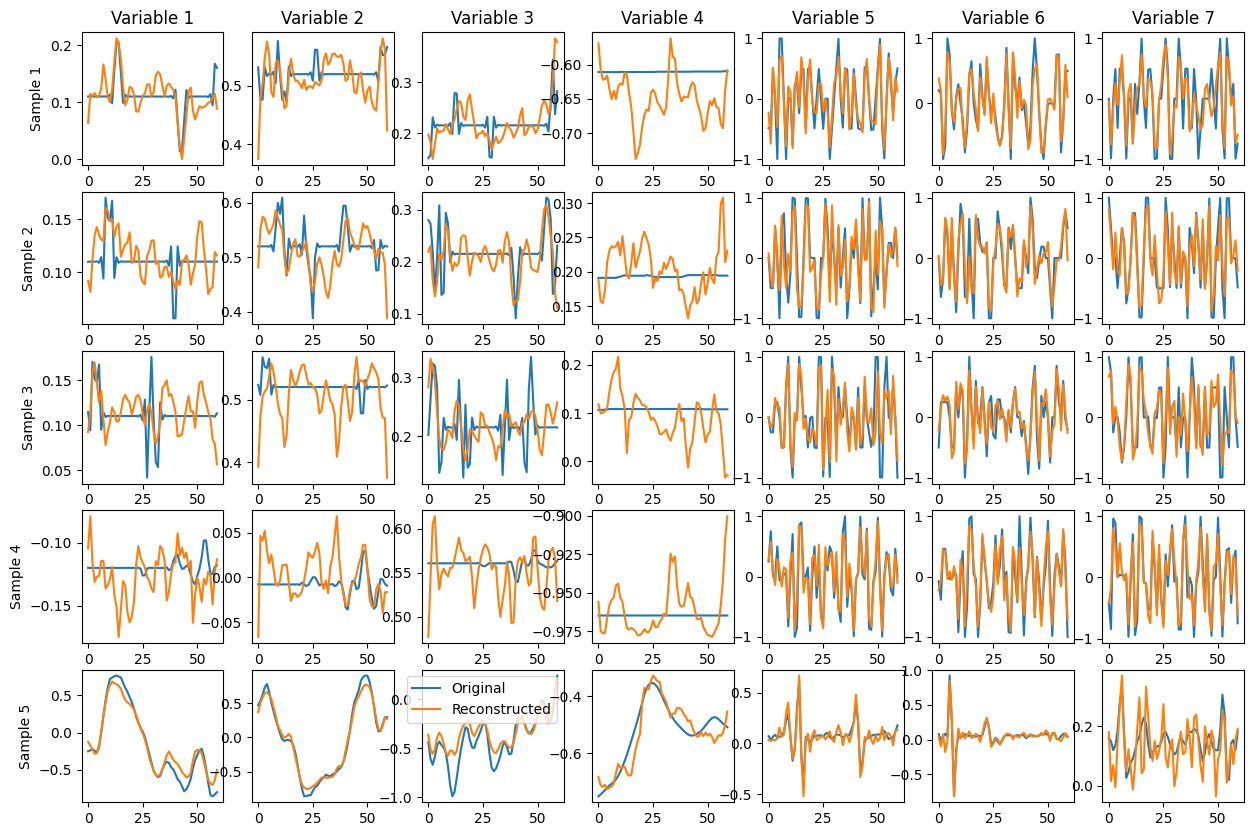

In [59]:
test_data = next(iter(dataloader))
reconstructed_data = model(test_data)

plot_reconstruction(test_data, reconstructed_data)